In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
colors = sns.color_palette()
sns.set_context("paper")
sns.set_style("ticks");

import urllib.request
import os
def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.
    
    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified 
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

# Example - Ornstein-Uhlenbeck Process

We are going to consider the Ornstein-Uhlenbeck process, given as:

$$
dX_t = -\lambda(X_t - \mu)dt + \sigma dW_t
$$

where $X_t$ is the process, $\lambda$ is the rate of mean reversion, $\mu$ is the mean of the process, $\sigma$ is the volatility of the process, $W_t$ is the Wiener process.

In [31]:
pip install optax

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [32]:
import pandas as pd
import datetime
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jax.random as jr
import optax

As as example we are going to consider the 2-year treasury note yield. This 2-year treasury note is a debt issued by the United States Department of the Treasury that has a maturity of 2 years. The yield of this note is the return that an investor would get if they bought the note and held it until maturity. The yield is expressed as a percentage of the note's face value. This rate is a significant indicator of the overall health of the economy, as it is influenced by the Federal Reserve's monetary policy, inflation, and the overall demand for U.S. Treasury notes. It is also very sensitive to changes in monteary policy, as it is a short-term debt, observed as volatile behavior. 

We are going to fit the Ornstein-Uhlenbeck process as the yield rate recovers from the COVID-19 induced recession. This model, also called the [Vasicek model](https://en.wikipedia.org/wiki/Vasicek_model) in finance is commonly used to describe the behavior of interest rates.

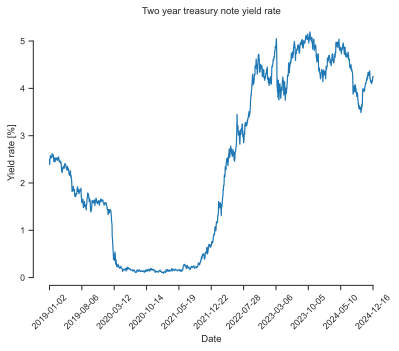

In [33]:
# Import two year T-bill data
url = 'https://github.com/PredictiveScienceLab/advanced-scientific-machine-learning/raw/refs/heads/main/book/data/twoYearTnote.csv'
download(url)
data = pd.read_csv("twoYearTnote.csv")
# remove nans
data = data.dropna()
raw_date = data['observation_date']
rate = data['DGS2']

# Plot the data with only 10 x axis ticks
plt.plot(raw_date, rate)
plt.xlabel("Date")
plt.ylabel("Yield rate [%]")
plt.title("Two year treasury note yield rate")
plt.xticks(ticks=plt.xticks()[0][::len(raw_date)//10], rotation=45)
sns.despine(trim=True)
plt.show()

You can see how in March 2020 the yield rate dropped significantly due to the COVID-19 pandemic, and then it started to recover about 18 months later.

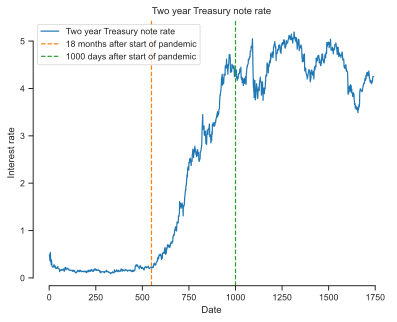

In [34]:
# Define Key dates
covid_start = '2020_03-12' # black thursday
recovery_start = '2021_09-12'

# Convert to datetime
covid_start = datetime.datetime.strptime(covid_start, "%Y_%m-%d")
recovery_start = datetime.datetime.strptime(recovery_start, "%Y_%m-%d")
recovery_start = (recovery_start - covid_start).days
date = pd.to_datetime(raw_date)
date = date - covid_start
date = date.dt.days
date = date.values

# Start data at the start of the pandemic
date_mask = date > 0
date = date[date_mask]
rate = rate[date_mask]

date = jnp.array(date, dtype=float)
rate = jnp.array(rate, dtype=float)

# Plot the data
plt.plot(date, rate, label='Two year Treasury note rate')
plt.axvline(recovery_start, color=colors[1], linestyle='--', label='18 months after start of pandemic')
plt.axvline(x=1000, color=colors[2], linestyle='--', label='1000 days after start of pandemic')
plt.xlabel("Date")
plt.ylabel("Interest rate")
plt.title("Two year Treasury note rate")
plt.legend()
sns.despine(trim=True)
plt.show()

We will call the rate at the beginning of the recovery $X_0$ and for round number sake, it appears that the rate has "recovered" about 1000 days after the market crash. We want to define this recovery so that we can empirically define the $\mu$, the mean that the process is reverting to. From here we will find the best parameters for the Ornstein-Uhlenbeck process that fits the data.

In [35]:
# Find the mean of rate until the beginning of the recovery
recovery_index = jnp.argmax(date >= recovery_start)
x0 = jnp.mean(rate[recovery_index])
mu = jnp.mean(rate[1000:])

print(f'The start of the process is {x0:.4}%')
print(f'The mean of the rate after 1000 days is {mu:.4}%')

# Make the data to start at the recovery index
recovery_days = date[recovery_index:] - recovery_start
recovery_rates = rate[recovery_index:]

The start of the process is 0.21%
The mean of the rate after 1000 days is 4.358%


Now that we have established $X_0$ and $\mu$, we can fit the mean reversion parameter $\lambda$. We will use the expectation of the process that we derived in lecture:

$$
\mathbb{E}[X_t] = X_0 e^{-\lambda t} + \mu (1 - e^{-\lambda t})
$$

We will just use a mean squared error loss function with a gradient descent optimizer to find the best $\lambda$ fit the data.

In [36]:
def exp_X(x0, mu, theta, t):
    return x0 * jnp.exp(-theta * t) + mu * (1 - jnp.exp(-theta * t))

def compute_loss(lam, X, t, x0, mu):
    # Calculate the expected value of X_t based on the Ornstein-Uhlenbeck process
    X_expected = exp_X(x0, mu, lam, t)
    # Calculate the mean squared error between observed X and expected X
    return jnp.mean((X - X_expected) ** 2)

# Create a function to fit the mean reversion parameter
def find_lam(X, t, x0, mu, lam0=1.0, learning_rate=0.01, max_iters=5000, tol=1e-3):
    # Initialize lam
    lam = jnp.array(lam0)
    # Define the optimizer
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(lam)

    # Optimization loop
    def step(lam, opt_state):
        # Compute the gradient of the loss with respect to lam
        loss, grad_loss = jax.value_and_grad(compute_loss)(lam, X, t, x0, mu)
        # Apply optimizer step
        updates, opt_state = optimizer.update(grad_loss, opt_state)
        lam = optax.apply_updates(lam, updates)
        return lam, opt_state, loss

    # Iterative optimization
    loss_evolution = []
    for i in range(max_iters):
        lam, opt_state, loss = step(lam, opt_state)
        loss_evolution.append(loss)
        # Check for convergence
        if loss < tol:
            print(f"Converged in {i} iterations")
            break

    return float(lam), jnp.array(loss_evolution)

Let's go ahead and find $\lambda$ feel free to play around with the optimizer and the starting point of $\lambda$ to adjust it closer to what you observe.

In [37]:
# Scaling the days to be between 0 and 1 for numerical stability
end_day = jnp.max(recovery_days)
s_days = recovery_days / end_day

# Fit the mean reversion parameter
lam, loss_evolution = find_lam(recovery_rates, s_days, x0, mu)

print(f"The estimated mean reversion parameter is {lam:.4}")

The estimated mean reversion parameter is 5.226


Okay, we have found a parameter, let's check the loss to make sure that our optimizer converged.

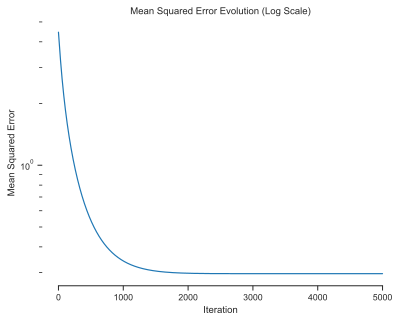

In [38]:
# Plot the loss evolution in log scale
plt.plot(loss_evolution)
plt.xlabel("Iteration")
plt.ylabel("Mean Squared Error")
plt.yscale('log')
plt.title("Mean Squared Error Evolution (Log Scale)")
sns.despine(trim=True)
plt.show()

Great, we have converged. Let's do a sanity check and plot the expected value of the process against the data.

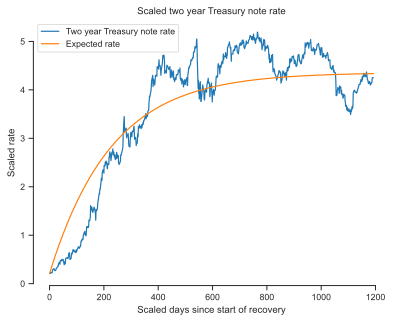

In [39]:
# Plot the expected value of X_t based on the Ornstein-Uhlenbeck process
t = jnp.linspace(0, 1, 100)
X_expected = exp_X(x0, mu, lam, t)
plt.plot(recovery_days, recovery_rates, label='Two year Treasury note rate')
plt.plot(t*end_day, X_expected, label='Expected rate')
plt.xlabel("Scaled days since start of recovery")
plt.ylabel("Scaled rate")
plt.title("Scaled two year Treasury note rate")
plt.legend()
sns.despine(trim=True)


Okay, that looks plausible. Now let's find the volatility parameter $\sigma$. We will use the variance of the process that we derived in lecture:

$$
\mathbb{V}[X_t] = \frac{\sigma^2}{2\lambda}(1 - e^{-2\lambda t})
$$

Now as time goes to infinity, the variance of the process should converge to $\frac{\sigma^2}{2\lambda}$. We can estimate our variance at the mean that we have empirically defined. We can then find the best $\sigma$ that fits the data.

In [40]:
def estimate_sigma(var, lam, t):
    return jnp.sqrt((2 * lam * var) / 1 - jnp.exp(-2 * lam * t))

# Estimate the variance of the rate after the recovery
X_var = jnp.var(recovery_rates[len(recovery_rates)//2:])
                
# Estimate the volatility sigma
sigma = estimate_sigma(X_var, lam, end_day)
print(f"The estimated volatility parameter is {sigma:.4}")


The estimated volatility parameter is 1.311


Okay, now all that's left is to simulate the process like we did for the stochastic exponential growth in the last notebook. We will again use the Euler-Maruyama discretization scheme. Notice the drift term is really the only thing that has changed.

In [41]:
# Create a function to simulate the Ornstein-Uhlenbeck process
def ou_step(carry, dt):
    key, mu, lam, sigma, x = carry
    key, subkey = jr.split(key)
    # Compute the drift term
    drift = lam * (mu - x) * dt
    # Compute the diffusion term
    diffusion = sigma * jnp.sqrt(dt) * jr.normal(subkey)
    # Compute the new value of X
    x_new = x + drift + diffusion
    return (key, mu, lam, sigma, x_new), x_new

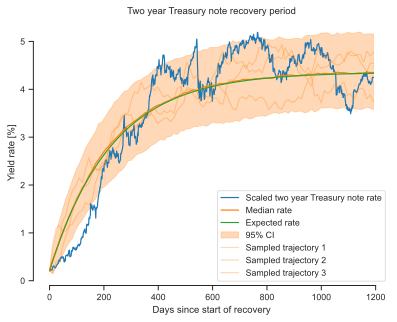

In [42]:
# Run a statstically significant number of simulations
n_samples = 1000
# Initialize the random number generator
sim_keys = jr.split(jr.PRNGKey(0), n_samples)
dt = jnp.diff(t)

all_Xt = []

# Simulate the Ornstein-Uhlenbeck process
for i in range(n_samples):
    init_carry = (sim_keys[i], mu, lam, sigma, x0)
    _, X_simulated = jax.lax.scan(ou_step, init_carry, dt)
    Xt = jnp.concatenate((jnp.array([x0]), X_simulated))
    all_Xt.append(Xt)

all_Xt = jnp.array(all_Xt)

X_median = jnp.median(all_Xt, axis=0)
X_lower = jnp.quantile(all_Xt, 0.025, axis=0)
X_upper = jnp.quantile(all_Xt, 0.975, axis=0)

# Plot the expected value of X_t based on the Ornstein-Uhlenbeck process
plt.plot(recovery_days, recovery_rates, label='Scaled two year Treasury note rate')
plt.plot(t*end_day, X_median, label='Median rate')
plt.plot(t*end_day, X_expected, label='Expected rate')
plt.fill_between(t*end_day, X_lower, X_upper, alpha=0.3, color=colors[1], label='95% CI')
# Plot some samples
for i in range(3):
    plt.plot(t*end_day, all_Xt[i], color=colors[1], alpha=0.3, label=f'Sampled trajectory {i+1}')
plt.xlabel("Days since start of recovery")
plt.ylabel("Yield rate [%]") 
plt.title("Two year Treasury note recovery period")
plt.legend()
sns.despine(trim=True)
plt.show()

Looks good! The expectation that we have derived is in good agreement with the median value from our simulations. The data is largely within our confidence interval. The samples look like reasonable paths for the evolution of the yield rate. 

The model will not be perfect as the yield rate is influenced by many factors, including the monetary policy set by the Federal reserve, but it is a good start to understanding the behavior of the yield rate.

Feel free to play with the parameters, maybe change the starting point of the recovery, or the time it takes to recover. You can also try to fit the model to other data, like the 10-year treasury note yield. Take a look at [FRED](https://fred.stlouisfed.org/) for more data to play with.